In [1]:
%matplotlib inline

# Enable interactive plot
#%matplotlib notebook

from matplotlib import pyplot as plt


from pathlib import Path
import numpy as np
import xarray as xr
import dask

from xgcm import Grid


import numpy.ma as ma

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from Routines import filtres 
from Routines import utilities

In [2]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster()
client = Client(address=cluster)
client 
# need bokeh installed, and open the dashboard link to see the workers working, memory usage, etc.
# The dashboard is really useful to see the RAM use and other informations.

<Client: 'tcp://127.0.0.1:45101' processes=13 threads=104, memory=754.53 GiB>

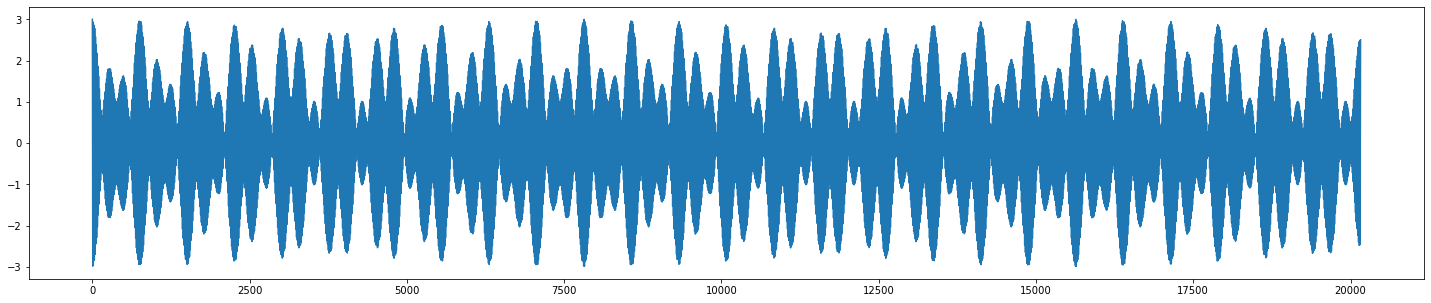

In [3]:
plt.rcParams['figure.figsize'] = (25, 5)

time = np.arange(24*840)
plt.plot(np.cos(2*3.14*time/12)+np.cos(2*3.14*time/12.4)+np.cos(2*3.14*time/12.6))

# Space Domain

In [4]:
horizontal_chunking = 300
vertical_chunking = 100


# Routines

In [5]:
def masking(data, mask):
    data = data.assign_coords(mask=(["y_c", "x_c"], mask.data))
    data = data.where(data.mask)
    
    return data



def smoothing(data, sigma, xgrid):
    data2 = data.where(np.isfinite(data), 0.)
    for i in range(0,3,1):
        data1 = filtres.gauss_filt(data2, sigma=sigma)
        data2 = xr.where(np.isnan(data.values) == True, data1, data)      
        #epsilon = xr.where(np.isnan(data.values) == True, np.sqrt(xgrid.interp(xgrid.diff(data1, 'X', boundary= 'extend'), 'X', boundary= 'extend')**2 + xgrid.interp(xgrid.diff(data1, 'Y', boundary= 'extend'), 'Y', boundary= 'extend')**2),0)   
        #epsilon = epsilon.sum('x_c').sum('y_c').values
        #print(epsilon)
    return data1



# Topo Domain

In [ ]:
plt.rcParams['figure.figsize'] = (20, 20)

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

H = xr.open_zarr("/media/Stockage2/abella/eNATL60_30d-mean_vmodes_20091227.zarr")
H = H.norm

GridF = xr.open_zarr("/home/abella/codes/eNATL60_rest_grid.zarr")
GridFS = GridF.isel(x_c=range(0,5800,1))

Meso = xr.open_zarr("/media/Stockage2/abella/Big_article/Meso_250m.zarr")
Umeso = Meso.Umeso.chunk({'x_c':-1, 'y_c':-1}).isel(x_c=range(0,5800,1))
Vmeso = Meso.Vmeso.chunk({'x_c':-1, 'y_c':-1}).isel(x_c=range(0,5800,1))



A = len(GridF.coords["x_c"].values)
B = len(GridF.coords["y_c"].values)


reduction_factor = 10
LatS =  GridFS.llat_cc.isel({d:slice(0, None,reduction_factor) for d in ["x_c", "y_c"]})
LonS =  GridFS.llon_cc.isel({d:slice(0, None,reduction_factor) for d in ["x_c", "y_c"]})
Umeso = Umeso.isel({d:slice(0, None,reduction_factor) for d in ["x_c", "y_c"]})
Vmeso = Vmeso.isel({d:slice(0, None,reduction_factor) for d in ["x_c", "y_c"]})
NormMeso = np.sqrt(Umeso**2 + Vmeso**2)

fig, axes = plt.subplots(constrained_layout=True, subplot_kw={'projection': ccrs.Mollweide(central_longitude=-60.0)})


HS = H.isel(x_c=range(0,5800,1))
axes.set_extent([-98,-5,7,58])
D = axes.pcolormesh(GridFS.llon_cc, GridFS.llat_cc, HS, transform=ccrs.PlateCarree()) 

axes.streamplot(LonS.values, LatS.values, Umeso.values, Vmeso.values, density = 2, color='red', linewidth=NormMeso.values*10, transform=ccrs.PlateCarree())
axes.coastlines()
axes.set_title("Bathymetry of the domain of interest" ,pad=20, fontsize=30 )
gl = axes.gridlines(draw_labels=True,  dms=True, x_inline=False, y_inline=False)
axes.add_feature(cfeature.LAND, facecolor="lightgray")
    
C = plt.colorbar(D, ax= axes, shrink = 0.5)
C.set_label(label=' Depth (m)', size=20, weight='bold')
C.ax.tick_params(labelsize=20)
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20, 'color': 'black'}

color_domain= 'firebrick'


#Gulf Stream
Xa = GridF.llon_cc.isel(x_c=1300, y_c=1800)
Xb = GridF.llon_cc.isel(x_c=2800, y_c=1800)
Ya = GridF.llat_cc.isel(x_c=1300, y_c=1800)
Yb = GridF.llat_cc.isel(x_c=1300, y_c=2700)

axes.plot([Xa, Xb, Xb, Xa, Xa], [Ya, Ya, Yb, Yb, Ya], color=color_domain, linewidth=2, marker=',', transform=ccrs.Geodetic())
axes.text(-600000, 4700000, 'GS', color=color_domain, fontsize= 25)

#Azores
Xa = GridF.llon_cc.isel(x_c=3600, y_c=1400)
Xb = GridF.llon_cc.isel(x_c=4500, y_c=1400)
Ya = GridF.llat_cc.isel(x_c=3600, y_c=1400)
Yb = GridF.llat_cc.isel(x_c=3600, y_c=2300)

axes.plot([Xa, Xb, Xb, Xa, Xa], [Ya, Ya, Yb, Yb, Ya], color=color_domain, linewidth=2, marker=',', transform=ccrs.Geodetic())
axes.text(2300000, 4000000, 'AZ', color=color_domain, fontsize= 25)

#Nordic Europe
Xa = GridF.llon_cc.isel(x_c=4600, y_c=3300)
Xb = GridF.llon_cc.isel(x_c=5600, y_c=3300)
Ya = GridF.llat_cc.isel(x_c=4600, y_c=3300)
Yb = GridF.llat_cc.isel(x_c=4600, y_c=4600)

axes.plot([Xa, Xb, Xb, Xa, Xa], [Ya, Ya, Yb, Yb, Ya], color=color_domain, linewidth=2, marker=',', transform=ccrs.Geodetic())
axes.text(3000000, 6800000, 'NE', color=color_domain, fontsize= 25)


#Bay of Biscay
Xa = GridF.llon_cc.isel(x_c=4600, y_c=2400)
Xb = GridF.llon_cc.isel(x_c=5800, y_c=2400)
Ya = GridF.llat_cc.isel(x_c=4600, y_c=2400)
Yb = GridF.llat_cc.isel(x_c=4600, y_c=3200)

axes.plot([Xa, Xb, Xb, Xa, Xa], [Ya, Ya, Yb, Yb, Ya], color=color_domain, linewidth=2, marker=',', transform=ccrs.Geodetic())
axes.text(3500000, 5500000, 'BB', color=color_domain, fontsize= 25)


#Labrador
Xa = GridF.llon_cc.isel(x_c=1900, y_c=3600)
Xb = GridF.llon_cc.isel(x_c=3400, y_c=3600)
Ya = GridF.llat_cc.isel(x_c=1900, y_c=3600)
Yb = GridF.llat_cc.isel(x_c=1900, y_c=4700)

axes.plot([Xa, Xb, Xb, Xa, Xa], [Ya, Ya, Yb, Yb, Ya], color=color_domain, linewidth=2, marker=',', transform=ccrs.Geodetic())
axes.text(0, 6600000, 'LA', color=color_domain, fontsize= 25)

#Caraibe
Xa = GridF.llon_cc.isel(x_c=1100, y_c=300)
Xb = GridF.llon_cc.isel(x_c=2300, y_c=300)
Ya = GridF.llat_cc.isel(x_c=1100, y_c=300)
Yb = GridF.llat_cc.isel(x_c=1100, y_c=1100)

axes.plot([Xa, Xb, Xb, Xa, Xa], [Ya, Ya, Yb, Yb, Ya], color=color_domain, linewidth=2, marker=',', transform=ccrs.Geodetic())
axes.text(-1000000, 2000000, 'CA', color=color_domain, fontsize= 25)

#Sahara
Xa = GridF.llon_cc.isel(x_c=4200, y_c=400)
Xb = GridF.llon_cc.isel(x_c=5200, y_c=400)
Ya = GridF.llat_cc.isel(x_c=4200, y_c=400)
Yb = GridF.llat_cc.isel(x_c=4200, y_c=1400)

axes.plot([Xa, Xb, Xb, Xa, Xa], [Ya, Ya, Yb, Yb, Ya], color=color_domain, linewidth=2, marker=',', transform=ccrs.Geodetic())
axes.text(3600000, 2600000, 'SA', color=color_domain, fontsize= 25)
plt.savefig('Big_article_topo_domain.png', facecolor='white', bbox_inches='tight')

distributed.nanny - WARNING - Restarting worker


# Map div smooth

In [ ]:
plt.rcParams['figure.figsize'] = (20, 14)




DivF = xr.open_zarr("/home/abella/codes/Divf_monthly_base_temporal_mean.zarr")
DivF = DivF.DivF#.mean(dim='t', skipna=True)
xgrid = Grid(DivF, periodic=None)
border=len(DivF.y_c)

GridF = xr.open_zarr("/home/abella/codes/eNATL60_rest_grid.zarr")
GridF = GridF.coarsen(x_c=2, boundary="trim").mean()
GridF = GridF.coarsen(y_c=2, boundary="trim").mean()
A = len(GridF.coords["x_c"].values)
B = len(GridF.coords["y_c"].values)
GridF = GridF.isel(x_c=range(0,2900,1), y_c=range(10, border,1))
DivF = DivF.isel(x_c=range(0,2900,1), y_c=range(10, border,1))

H = xr.open_zarr("/media/Stockage2/abella/eNATL60_30d-mean_vmodes_20091227.zarr")
H = H.norm
H = H.coarsen(x_c=2, boundary="trim").mean()
H = H.coarsen(y_c=2, boundary="trim").mean()
H = H.isel(x_c=range(0,2900,1), y_c=range(10, border,1))



def Div_plot(vmin, field, title, name):
    fig, axis = plt.subplots(constrained_layout=True, subplot_kw={'projection': ccrs.Mollweide(central_longitude=-60.0)})

    D = axis.pcolormesh(GridF.llon_cc, GridF.llat_cc, masking(smoothing(masking(field, GridF.tmask.isel(z_c=50)), 20, xgrid), GridF.tmask.isel(z_c=50)), cmap="bwr", vmin=-vmin, vmax = vmin, transform=ccrs.PlateCarree())
    axis.set_extent([-98,-5,7,58])
    axis.contour(GridF.llon_cc, GridF.llat_cc, H, levels=[1700], colors=['darkslategray'], linewidths = 1, transform=ccrs.PlateCarree())
    axis.coastlines()
    #axis.set_title(title ,pad=15, fontsize=24 )
    gl = axis.gridlines(draw_labels=True,  dms=True, x_inline=False, y_inline=False)
    axis.add_feature(cfeature.LAND, facecolor="lightgray")
    gl.xlabel_style = {'size': 40, 'color': 'black'}
    gl.ylabel_style = {'size': 40, 'color': 'black'}
    C = plt.colorbar(D, ax= axis, shrink = 0.7)
    C.set_label(label='W.m/kg', size=40, weight='bold')
    C.ax.tick_params(labelsize=40)
    C.ax.yaxis.offsetText.set(size=40)
    gl.top_labels = False
    gl.right_labels = False
    
    plt.savefig('Big_article_flux_divergence_mode_{}.png'.format(name), facecolor='white', bbox_inches='tight')




Div_plot(0.000025, masking(smoothing(DivF.isel(mode=1), 15, xgrid), GridF.tmask.isel(z_c=50)), "Temporal mean of energy flux \n divergence, mode 1", 1)
Div_plot(0.00001, masking(smoothing(DivF.isel(mode=2), 15, xgrid), GridF.tmask.isel(z_c=50)), "Temporal mean of energy flux \n divergence, mode 2", 2)
Div_plot(0.00001, masking(smoothing(DivF.isel(mode=3), 15, xgrid), GridF.tmask.isel(z_c=50)), "Temporal mean of energy flux \n divergence, mode 3", 3)




# Coupling maps

In [ ]:
plt.rcParams['figure.figsize'] = (20, 13)




def Div_plot(vmin, field, title, name):
    fig, axis = plt.subplots(constrained_layout=True, subplot_kw={'projection': ccrs.Mollweide(central_longitude=-60.0)})

    D = axis.pcolormesh(GridF.llon_cc, GridF.llat_cc, masking(smoothing(masking(field, GridF.tmask.isel(z_c=50)), 20, xgrid), GridF.tmask.isel(z_c=50)), cmap="bwr", vmin=-vmin, vmax = vmin, transform=ccrs.PlateCarree()) 
    axis.contour(GridF.llon_cc, GridF.llat_cc, H, levels=[1700], colors=['darkslategray'], linewidths = 1, transform=ccrs.PlateCarree())
    axis.set_extent([-98,-5,7,58])
    axis.coastlines()
    #axis.set_title(title ,pad=5, fontsize=25 )
    gl = axis.gridlines(draw_labels=True,  dms=True, x_inline=False, y_inline=False)
    axis.add_feature(cfeature.LAND, facecolor="lightgray")
    gl.xlabel_style = {'size': 40, 'color': 'black'}
    gl.ylabel_style = {'size': 40, 'color': 'black'}
    C = plt.colorbar(D, ax= axis, shrink = 0.8)
    C.set_label(label='W.m/kg', size=40, weight='bold')
    C.ax.tick_params(labelsize=40)
    C.ax.yaxis.offsetText.set(size=40)
    gl.top_labels = False
    gl.right_labels = False
    
    plt.savefig('Big_article_maps_{}.png'.format(name), facecolor='white', bbox_inches='tight')
    
    
    
    
DivF = xr.open_zarr("/home/abella/codes/Divf_monthly_base_temporal_mean.zarr")
DivF = DivF.DivF#.mean(dim='t', skipna=True)
border=len(DivF.y_c)
xgrid = Grid(DivF, periodic=None)
    


Adv = xr.open_zarr("/media/Stockage2/abella/Big_article/Advection_monthly_base_temporal_mean.zarr")
Adv = Adv.Advection
GridF = xr.open_zarr("/home/abella/codes/eNATL60_rest_grid.zarr")
GridF = GridF.coarsen(x_c=2, boundary="trim").mean()
GridF = GridF.coarsen(y_c=2, boundary="trim").mean()
A = len(GridF.coords["x_c"].values)
B = len(GridF.coords["y_c"].values)
GridF = GridF.isel(x_c=range(0,2900,1), y_c=range(10, border,1))
Adv = Adv.isel(x_c=range(0, 2900,1), y_c=range(10, border,1))

Cmn = xr.open_zarr("/media/Stockage2/abella/Big_article/Cmn_Full_monthly_base_temporal_mean.zarr")
Cmn = Cmn.CmnFull
Cmn = Cmn.isel(x_c=range(0,2900,1), y_c=range(10, border,1))

V_shear = xr.open_zarr("/media/Stockage2/abella/Big_article/vertical_shear_monthly_base_temporal_mean.zarr")
V_shear = V_shear.HumSUMnUzwn
V_shear = V_shear.isel(x_c=range(0,2900,1), y_c=range(10, border,1))

Bsteady = xr.open_zarr("/media/Stockage2/abella/Big_article/Bcontribution_steady_monthly_base_temporal_mean.zarr")
Bsteady = Bsteady.Bsteady
Bsteady = Bsteady.isel(x_c=range(0,2900,1), y_c=range(10, border,1))


H = xr.open_zarr("/media/Stockage2/abella/eNATL60_30d-mean_vmodes_20091227.zarr")
H = H.norm
H = H.coarsen(x_c=2, boundary="trim").mean()
H = H.coarsen(y_c=2, boundary="trim").mean()
H = H.isel(x_c=range(0,2900,1), y_c=range(10, border,1))

Cmn_Plot = Cmn.isel(mode=1, modm=2)*0
Adv_Plot = Adv.isel(mode=1, modm=2)*0
V_shear_Plot = V_shear.isel(mode=1, modm=2)*0
Bsteady_Plot = Bsteady.isel(mode=1, modm=2)*0
for i in [1,2,3,4]:
    Cmn_Plot = Cmn_Plot + 0.5*(Cmn.isel(mode=1, modm=i) - Cmn.isel(mode=i, modm=1))
    Adv_Plot = Adv_Plot + 0.5*(-Adv.isel(mode=1, modm=i) + Adv.isel(mode=i, modm=1))
    V_shear_Plot = V_shear_Plot + 0.5*(-V_shear.isel(mode=1, modm=i) - V_shear.isel(mode=i, modm=1))
    Bsteady_Plot = Bsteady_Plot + 0.5*(Bsteady.isel(mode=1, modm=i) + Bsteady.isel(mode=i, modm=1))
    
#Cmn_Plot = Cmn_Plot.sum('modm')
#Adv_Plot = Adv_Plot.sum('modm')
#V_shear_Plot = V_shear_Plot.sum('modm')
#Bsteady_Plot = Bsteady_Plot.sum('modm')

Div_plot(0.00002, Cmn_Plot, "Temporally averaged anti-symmetric \n topographic interraction $\sum_j C_{1j}$", 'Cmn')
Div_plot(0.00001, Adv_Plot, "Temporally averaged anti-symmetric \n advection interraction $\sum_j A_{1j}$", 'Adv')
Div_plot(0.00001, V_shear_Plot, "Temporally averaged symmetric \n vertical shear interraction $\sum_j V_{1j}$", 'VShear')
Div_plot(0.00001, Bsteady_Plot, "Temporally averaged symmetric \n buoyancy interraction $\sum_j B^{os}_{1j}$", 'Buoy')



#plt.savefig('Big_article_maps.png', facecolor='white', bbox_inches='tight')

# Residual

In [ ]:
plt.rcParams['figure.figsize'] = (20, 13)




DivF = xr.open_zarr("/home/abella/codes/Divf_monthly_base_temporal_mean.zarr")
DivF = DivF.DivF#.mean(dim='t', skipna=True)
xgrid = Grid(DivF, periodic=None)

Residu = xr.open_zarr("/media/Stockage2/abella/Big_article/Residu_mean.zarr")
Residu = Residu.Residu#.isel(mode=1)#.mean(dim='t', skipna=True)

GridF = xr.open_zarr("/home/abella/codes/eNATL60_rest_grid.zarr")
GridF = GridF.coarsen(x_c=2, boundary="trim").mean()
GridF = GridF.coarsen(y_c=2, boundary="trim").mean()
A = len(GridF.coords["x_c"].values)
B = len(GridF.coords["y_c"].values)

border=len(DivF.y_c)

GridF = GridF.isel(x_c=range(0,2900,1), y_c=range(10, border,1))
DivF = DivF.isel(x_c=range(0,2900,1), y_c=range(10, border,1))
Residu = Residu.isel(x_c=range(0,2900,1), y_c=range(10, border,1))

H = xr.open_zarr("/media/Stockage2/abella/eNATL60_30d-mean_vmodes_20091227.zarr")
H = H.norm
H = H.coarsen(x_c=2, boundary="trim").mean()
H = H.coarsen(y_c=2, boundary="trim").mean()
H = H.isel(x_c=range(0,2900,1), y_c=range(10, border,1))


def Div_plot(vmin, field, title, name):
    
    fig, axis = plt.subplots(constrained_layout=True, subplot_kw={'projection': ccrs.Mollweide(central_longitude=-60.0)})

    D = axis.pcolormesh(GridF.llon_cc, GridF.llat_cc, masking(smoothing(masking(field, GridF.tmask.isel(z_c=50)), 20, xgrid), GridF.tmask.isel(z_c=50)), cmap="bwr", vmin=-vmin, vmax = vmin, transform=ccrs.PlateCarree())
    axis.contour(GridF.llon_cc, GridF.llat_cc, H, levels=[1700], colors=['darkslategray'], linewidths = 1, transform=ccrs.PlateCarree())
    axis.coastlines()
    axis.set_extent([-98,-5,7,58])
    #axis.set_extent([-100, 0, 6, 70], crs=ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True,  dms=True, x_inline=False, y_inline=False)
    axis.add_feature(cfeature.LAND, facecolor="lightgray")
    C = plt.colorbar(D, ax= axis, shrink = 0.75)
    C.set_label(label='W.m/kg', size=40, weight='bold')
    C.ax.tick_params(labelsize=40)
    C.ax.yaxis.offsetText.set(size=40)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 40, 'color': 'black'}
    gl.ylabel_style = {'size': 40, 'color': 'black'}
    
    plt.savefig('Big_article_residual_{}.png'.format(name), facecolor='white', bbox_inches='tight')





Div_plot(0.000025, DivF.isel(mode=1), "mean flux divergence mode 1", 'div')
Div_plot(0.000025, Residu, "mean residual mode 1", 'res')




In [ ]:
fig, axes = plt.subplots()


DivF_mean = DivF#.mean(dim='t', skipna=True)
DivFHist = DivF_mean.stack(z=("x_c", "y_c"))
axes.hist(DivFHist.values, 500, weights=DivFHist.values)

Residu_mean = Residu#.mean(dim='t', skipna=True)
ResiduHist = Residu_mean.stack(z=("x_c", "y_c"))
axes.hist(ResiduHist.values, 500, weights=ResiduHist.values)

distributed.nanny - WARNING - Restarting worker


# Temporal variability causes

In [13]:
def Domain_selection(data, domain_name, Dict_domain):
    # Apply a selection along a domain boundaries to a dataset or datarray
    
    # input:
    # data: dataset or datarray to apply the selection on.
    # domain_name: str
    # Dict_domain: dictionnary
    
    # output:
    # data: dataset or datarray reduced to the selection area.
    
    Domain_coords = Dict_domain[domain_name]
    Horizontal_dim = [d for d in data.dims if d[0] in ['x', 'y']]
    sel = {d:Domain_coords[d[0]] for d in Horizontal_dim}
    
    return data.sel(sel)


def plot_quiver_pcolormesh(Fx, Fy, Adv, U, V, mask, reduction_factor, axes, title):
        
    Lon = GridF.llon_cc.isel(y_c=0)
    Lat = GridF.llat_cc.isel(x_c=0)
    Lon = Domain_selection(Lon, Domain, Dict_domain)
    Lat = Domain_selection(Lat, Domain, Dict_domain)
    LonR = Lon.isel({d:slice(0, None, reduction_factor*2) for d in ["x_c"]})
    LatR = Lat.isel({d:slice(0, None, reduction_factor*2) for d in ["y_c"]})
    LonMeso = Lon.isel({d:slice(0, None, reduction_factor) for d in ["x_c"]})
    LatMeso = Lat.isel({d:slice(0, None, reduction_factor) for d in ["y_c"]})
    LonAdv = Lon.isel({d:slice(0, None, 2) for d in ["x_c"]})
    LatAdv = Lat.isel({d:slice(0, None, 2) for d in ["y_c"]})
    

    
    Fx = Fx.isel({d:slice(0, None, reduction_factor*2) for d in ["x_c", "y_c"]})
    Fy = Fy.isel({d:slice(0, None, reduction_factor*2) for d in ["x_c", "y_c"]})
    maskRF = mask.isel({d:slice(0, None, reduction_factor*2) for d in ["x_c", "y_c"]})
    Fx = Fx.assign_coords(maskRF=(["y_c", "x_c"], maskRF.data))
    Fx = Fx.where(Fx.maskRF)
    Fy = Fy.assign_coords(maskRF=(["y_c", "x_c"], maskRF.data))
    Fy = Fy.where(Fy.maskRF)


    mask = mask.isel({d:slice(0, None, 2) for d in ["x_c", "y_c"]})
    
    Adv = Adv.assign_coords(mask=(["y_c", "x_c"], mask.data))
    Adv = Adv.where(Adv.mask)
    Adv = Adv.assign_coords(mask=(["y_c", "x_c"], mask.data))
    Adv = Adv.where(Adv.mask)
    
    X = Adv.coords["x_c"]
    Y = Adv.coords["y_c"]
    Xr = X.isel({d:slice(0, None,16) for d in ["x_c"]})
    Yr = Y.isel({d:slice(0, None,16) for d in ["y_c"]})
    Fx = Fx.assign_coords(x_c=("x_c", Xr.data))
    Fx = Fx.assign_coords(y_c=("y_c", Yr.data))
    Fy = Fy.assign_coords(x_c=("x_c", Xr.data))
    Fy = Fy.assign_coords(y_c=("y_c", Yr.data))
    
    
    VMIN = -0.00005

    im = axes.pcolormesh(LonAdv.values, LatAdv.values, Adv.isel(mode=1, modm=2), cmap='bwr', vmin = VMIN, vmax = -VMIN, transform=ccrs.PlateCarree())
    Q = axes.quiver(LonR.values, LatR.values, Fx.isel(mode=1).values, Fy.isel(mode=1).values, color='k', transform=ccrs.PlateCarree())
    
    U = U.isel({d:slice(0, None, reduction_factor) for d in ["x_c", "y_c"]})
    V = V.isel({d:slice(0, None, reduction_factor) for d in ["x_c", "y_c"]})
    U = U.mean(dim='t', skipna=True)
    V = V.mean(dim='t', skipna=True)
    
    NormMeso = np.sqrt(U**2 + V**2)*0.2
    
    H = xr.open_zarr("/media/Stockage2/abella/eNATL60_30d-mean_vmodes_20091227.zarr")
    H = Domain_selection(H.norm, Domain, Dict_domain_metric) 
    H = H.reset_coords(drop=True).astype(dtype=np.float32)
    H = H.coarsen(y_c=2, boundary="trim").mean()
    H = H.coarsen(x_c=2, boundary="trim").mean()
    axes.contour(X.x_c.values, Y.y_c.values, H, levels=[300,1000,2000,3000], colors=['darkslategray','darkslategray','darkslategray','darkslategray'], linewidths = 1, transform=ccrs.PlateCarree())

    
    S = axes.streamplot(LonMeso.values, LatMeso.values, U.values, V.values, color='green', linewidth= NormMeso.values*20, transform = ccrs.PlateCarree())
    C = plt.colorbar(im, ax= axes, shrink=0.33) 
    C.set_label(label='W.m/kg', size=13, weight='bold')
    C.ax.tick_params(labelsize=13)
    C.ax.yaxis.offsetText.set(size=13)
    
    gl = axes.gridlines(draw_labels=True,  dms=True, x_inline=False, y_inline=False)
    axes.add_feature(cfeature.LAND, facecolor="lightgray")
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13, 'color': 'black'}
    gl.ylabel_style = {'size': 13, 'color': 'black'}


CPU times: user 16.9 s, sys: 1.26 s, total: 18.1 s
Wall time: 20 s


<Figure size 720x1008 with 0 Axes>

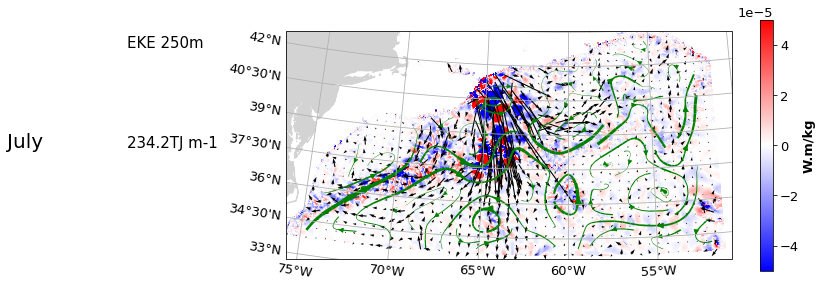

<Figure size 720x1008 with 0 Axes>

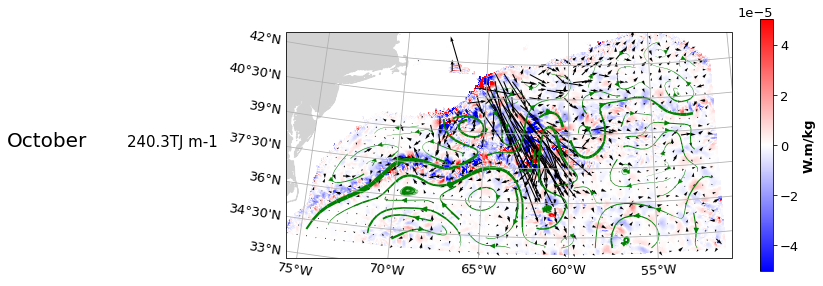

<Figure size 720x1008 with 0 Axes>

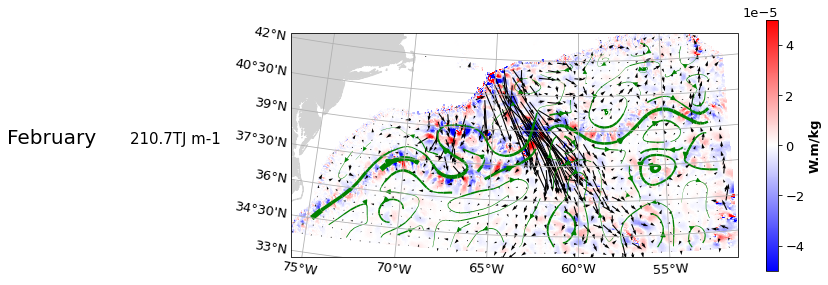

In [17]:
%%time









# need the .5 at the superior end because of x_r and y_r, if you want then to have the same number of point as x_c and y_c
Domain_Sahara_dict = dict(x=slice(4200, 5200.5), y=slice(400,1400.5))
Domain_Caraibe_dict = dict(x=slice(1100, 2300.5), y=slice(300,1100.5))
Domain_Gulfstream_dict = dict(x=slice(1300, 2800.5), y=slice(1800,2700.5))
Domain_Azores_dict = dict(x=slice(3600, 4500.5), y=slice(1400,2300.5))
Domain_North_Atlantic_dict = dict(x=slice(0,8354.5), y=slice(0,4729.5))
Domain_Bay_of_Biscay_dict = dict(x=slice(4600, 5800.5), y=slice(2400,3200.5))
Domain_Nordic_Europe_dict = dict(x=slice(4600,5600.5), y=slice(3300,4600.5))
Domain_Labrador_dict = dict(x=slice(1900, 3400.5), y=slice(3600,4700.5))

Dict_domain = ({'Gulf_Stream' : Domain_Gulfstream_dict, 'Azores' : Domain_Azores_dict, 'North_Atlantic' : Domain_North_Atlantic_dict, 
                'Nordic_Europe' : Domain_Nordic_Europe_dict, 'Sahara' : Domain_Sahara_dict, 'Caraibe' : Domain_Caraibe_dict,
               'Bay_of_Biscay' : Domain_Bay_of_Biscay_dict, 'Labrador' : Domain_Labrador_dict})

Domain_Sahara_dict_metric = dict(x=slice(4200, 5202.5), y=slice(400,1402.5))
Domain_Caraibe_dict_metric = dict(x=slice(1100, 2302.5), y=slice(300,1102.5))
Domain_Gulfstream_dict_metric = dict(x=slice(1300, 2802.5), y=slice(1800,2702.5))
Domain_Azores_dict_metric = dict(x=slice(3600, 4502.5), y=slice(1400,2302.5))
Domain_North_Atlantic_dict_metric = dict(x=slice(0,8354.5), y=slice(0,4729.5))
Domain_Bay_of_Biscay_dict_metric = dict(x=slice(4600, 5802.5), y=slice(2400,3202.5))
Domain_Nordic_Europe_dict_metric = dict(x=slice(4600,5602.5), y=slice(3300,4602.5))
Domain_Labrador_dict_metric = dict(x=slice(1900, 3402.5), y=slice(3600,4702.5))

Dict_domain_metric = ({'Gulf_Stream' : Domain_Gulfstream_dict_metric, 'Azores' : Domain_Azores_dict_metric, 'North_Atlantic' : Domain_North_Atlantic_dict_metric, 
                'Nordic_Europe' : Domain_Nordic_Europe_dict_metric, 'Sahara' : Domain_Sahara_dict_metric, 'Caraibe' : Domain_Caraibe_dict_metric,
               'Bay_of_Biscay' : Domain_Bay_of_Biscay_dict_metric, 'Labrador' : Domain_Labrador_dict_metric})







Domain = "Gulf_Stream"


GridF = xr.open_zarr("/home/abella/codes/eNATL60_rest_grid.zarr")
mask = GridF.tmask.isel(z_c=50)
mask = Domain_selection(mask, Domain, Dict_domain) 









F = xr.open_zarr("/media/Stockage2/abella/Big_article/Internal_tide_flux.zarr")
F = Domain_selection(F, Domain, Dict_domain) 
Fx7 = F.F7x
Fx10 = F.F10x
Fx2 = F.F2x
Fy7 = F.F7y
Fy10 = F.F10y
Fy2 = F.F2y


Mesoscale7 = xr.open_zarr("/media/Stockage2/abella/Big_article/Mesoscale7.zarr")
Mesoscale7 = Domain_selection(Mesoscale7, Domain, Dict_domain) 
Mesoscale10 = xr.open_zarr("/media/Stockage2/abella/Big_article/Mesoscale10.zarr")
Mesoscale10 = Domain_selection(Mesoscale10, Domain, Dict_domain) 
Mesoscale2 = xr.open_zarr("/media/Stockage2/abella/Big_article/Mesoscale2.zarr")
Mesoscale2 = Domain_selection(Mesoscale2, Domain, Dict_domain) 
U7 = Mesoscale7.Umeso_july
U10 = Mesoscale10.Umeso_october
U2 = Mesoscale2.Umeso_february
V7 = Mesoscale7.Vmeso_july
V10 = Mesoscale10.Vmeso_october
V2 = Mesoscale2.Vmeso_february


Mesoscale = xr.open_zarr("/media/Stockage2/abella/Big_article/Advection.zarr")
Mesoscale = Domain_selection(Mesoscale, Domain, Dict_domain) 
Adv7 = Mesoscale.Adv_july
Adv10 = Mesoscale.Adv_october
Adv2 = Mesoscale.Adv_february


e2t = Domain_selection(GridF.e2t, Domain, Dict_domain) 
e2t = e2t.astype(dtype=np.float32)
e1t = Domain_selection(GridF.e1t, Domain, Dict_domain) 
e1t = e1t.astype(dtype=np.float32)





reduction_factor = 16

plt.rcParams['figure.figsize'] = (10, 14)
fig = plt.figure(constrained_layout=True)
fig, axes = plt.subplots(subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-60.0)})
plot_quiver_pcolormesh(Fx7, Fy7, Adv7, U7, V7, mask, reduction_factor, axes, '')
Ec7 = (U7**2 + V7**2)*0.5
Ec7 = (Ec7*e1t*e2t*1026).sum('x_c').sum('y_c')
Ec7 = Ec7.mean(dim='t', skipna=True)
axes.text(-2200000, 4700000, 'EKE 250m', fontsize = 15)
axes.text(-2200000, 4200000, '%.1f' 'TJ m-1' % (Ec7.values/1e12) , fontsize = 15)
axes.text(-2800000, 4200000, 'July', fontsize = 20)
plt.savefig('Big_article_temporal_variability_GS_map_july.png', bbox_inches='tight', facecolor='white')

plt.rcParams['figure.figsize'] = (10, 14)
fig = plt.figure(constrained_layout=True)
fig, axes = plt.subplots(subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-60.0)})
plot_quiver_pcolormesh(Fx10, Fy10, Adv10, U10, V10, mask, reduction_factor, axes, '')
Ec10 = (U10**2 + V10**2)*0.5
Ec10 = (Ec10*e1t*e2t*1026).sum('x_c').sum('y_c')
Ec10 = Ec10.mean(dim='t', skipna=True)
axes.text(-2200000, 4200000, '%.1f' 'TJ m-1' % (Ec10.values/1e12) , fontsize = 15)
axes.text(-2800000, 4200000, 'October', fontsize = 20)
plt.savefig('Big_article_temporal_variability_GS_map_october.png', bbox_inches='tight', facecolor='white')

plt.rcParams['figure.figsize'] = (10, 14)
fig = plt.figure(constrained_layout=True)
fig, axes = plt.subplots(subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-60.0)})
plot_quiver_pcolormesh(Fx2, Fy2, Adv2, U2, V2, mask, reduction_factor, axes, '')
Ec2 = (U2**2 + V2**2)*0.5
Ec2 = (Ec2*e1t*e2t*1026).sum('x_c').sum('y_c')
Ec2 = Ec2.mean(dim='t', skipna=True)
axes.text(-2200000, 4200000, '%.1f' 'TJ m-1' % (Ec2.values/1e12) , fontsize = 15)
axes.text(-2800000, 4200000, 'February', fontsize = 20)
plt.savefig('Big_article_temporal_variability_GS_map_february.png', bbox_inches='tight', facecolor='white')

CPU times: user 3.14 s, sys: 212 ms, total: 3.35 s
Wall time: 4.2 s


<Figure size 504x360 with 0 Axes>

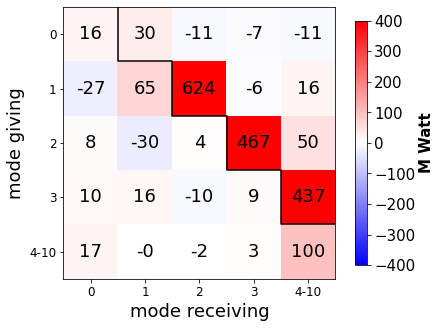

<Figure size 504x360 with 0 Axes>

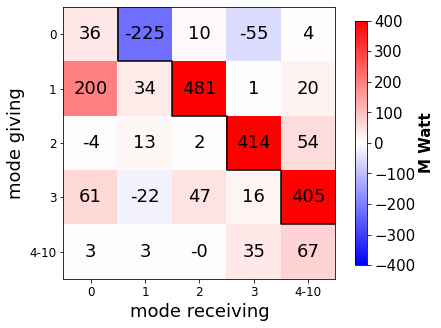

<Figure size 504x360 with 0 Axes>

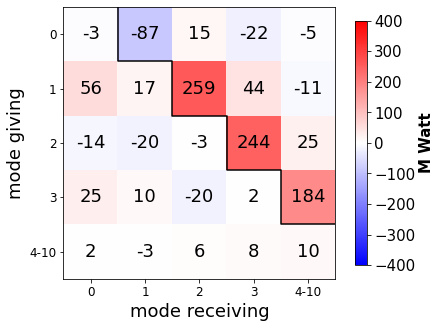

In [23]:
%%time



Advection_table = xr.open_zarr("/media/Stockage2/abella/Big_article/Advection_table.zarr")
Adv7f = Advection_table.Adv_july
Adv10f = Advection_table.Adv_october
Adv2f = Advection_table.Adv_february
    
    
    
    
def plot_tab(data, magnitude, VMIN, title):
    plt.rcParams['figure.figsize'] = (7, 5)
    fig = plt.figure(constrained_layout=True)
    fig, axes = plt.subplots()
    
    VMAX = -VMIN
    im = axes.imshow(data*magnitude, cmap= 'bwr', vmin= VMIN, vmax= VMAX)
    #axes.set_title(title,pad=10, fontsize=title_fontsize )
    axes.tick_params(labelsize =tick_fontsize)
    axes.set_xlabel('mode receiving', fontsize=axes_name_fontsize)
    axes.set_ylabel('mode giving', fontsize=axes_name_fontsize)
    axes.tick_params(axis='x', labelsize=tick_fontsize)
    axes.tick_params(axis='y', labelsize=tick_fontsize)
    
    axes.plot(upper_diag_x, upper_diag_y, color='k')
    
    y_pos = np.arange(len(modes))
    axes.set_yticks(y_pos, labels=modes)
    x_pos = np.arange(len(modes))
    axes.set_xticks(x_pos, labels=modes)
    for i in range(0,5,1):
        for j in range(0,5,1):
            axes.text(j,i , '%.0f' % float(data[i,j]*magnitude),ha='center', va="center", fontsize=text_fontsize)
    C = plt.colorbar(im, ax= axes, shrink=0.9)
    if magnitude == 1e-9:
        C.set_label(label='G Watt',size=15,weight='bold')
    if magnitude == 1e-6:
        C.set_label(label='M Watt',size=15,weight='bold')
    C.ax.tick_params(labelsize=colorbar_fontsize)
    
    plt.savefig('Big_article_temporal_variability_GS_Tab_{}.png'.format(title), bbox_inches='tight', facecolor='white')
 

    
modes = ('0', '1', '2', '3', '4-10')
kmax = 5
axes_name_fontsize = 18
title_fontsize = 16
text_fontsize = 18
tick_fontsize = 12
colorbar_fontsize = 15
upper_diag_x=[0.5,0.5,1.5,1.5,2.5,2.5,3.5,3.5,4.5]
upper_diag_y=[-0.5,0.5,0.5,1.5,1.5,2.5,2.5,3.5,3.5]


VMIN = -400
plot_tab(Adv7f, 1e-6, VMIN, 'july')
plot_tab(Adv10f, 1e-6, VMIN, 'october')
plot_tab(Adv2f, 1e-6, VMIN, 'february')







# Annexe Stratification

/tmp/ipykernel_2002567/4065323610.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  GridF = GridF.coarsen(y_c=2, boundary="trim").mean()


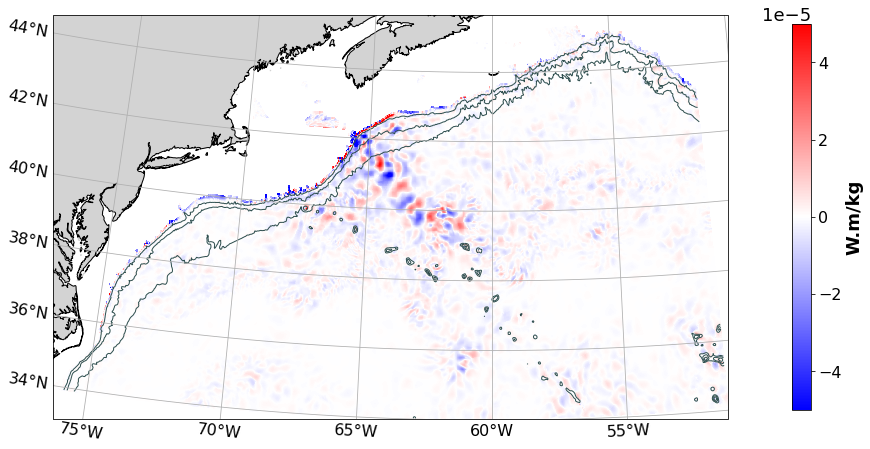

In [10]:
## Nterm_month and Nterm_simu have already been masked on datarmor

H = xr.open_zarr("/media/Stockage2/abella/eNATL60_30d-mean_vmodes_20091227.zarr")
H = H.norm.isel(x_c=slice(1300, 2800), y_c=slice(1800,2700))
H = H.coarsen(x_c=2, boundary="trim").mean()
H = H.coarsen(y_c=2, boundary="trim").mean()



GridF = xr.open_zarr("/home/abella/codes/eNATL60_rest_grid.zarr")
GridF = GridF.isel(x_c=slice(1300, 2800), y_c=slice(1800,2700))
GridF = GridF.coarsen(x_c=2, boundary="trim").mean()
GridF = GridF.coarsen(y_c=2, boundary="trim").mean()


Nterm_month = xr.open_zarr("/media/Stockage2/abella/Big_article/Stratification_coupling_monthly.zarr")
Nterm_month = Nterm_month.Nvariable.isel(mode=1, modm=3)

Nterm_simu = xr.open_zarr("/media/Stockage2/abella/Big_article/Stratification_coupling_simulation.zarr")
Nterm_simu = Nterm_simu.Nvariable.isel(mode=1, modm=3)





plt.rcParams['figure.figsize'] = (12, 12)

fig, axes = plt.subplots(constrained_layout=True, subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-60.0)})

D = axes.pcolormesh(GridF.llon_cc, GridF.llat_cc, Nterm_simu, cmap="bwr", vmin=-5e-5, vmax=5e-5, transform=ccrs.PlateCarree()) 
axes.contour(GridF.llon_cc, GridF.llat_cc, H, levels=[1000, 2000, 3000], colors=['darkslategray'], linewidths = 1, transform=ccrs.PlateCarree())
axes.coastlines()
#axes.set_title('Simulation averaged base' ,pad=15, fontsize=25 )
gl = axes.gridlines(draw_labels=True)
axes.add_feature(cfeature.LAND, facecolor="lightgray")
C = plt.colorbar(D, ax= axes, shrink = 0.45)
C.set_label(label='W.m/kg', size=18, weight='bold')
C.ax.tick_params(labelsize=16)
C.ax.yaxis.offsetText.set(size=18)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}
plt.savefig('Big_article_annexe_strat_pt1_simulation.png', facecolor='white', bbox_inches='tight')




plt.rcParams['figure.figsize'] = (12, 12)

fig, axes = plt.subplots(constrained_layout=True, subplot_kw={'projection': ccrs.AlbersEqualArea(central_longitude=-60.0)})

D = axes.pcolormesh(GridF.llon_cc, GridF.llat_cc, Nterm_month, cmap="bwr", vmin=-1e-7, vmax=1e-7, transform=ccrs.PlateCarree()) 
axes.contour(GridF.llon_cc, GridF.llat_cc, H, levels=[1000, 2000, 3000], colors=['darkslategray'], linewidths = 1, transform=ccrs.PlateCarree())
axes.coastlines()
#axes.set_title('Monthly averaged base' ,pad=15, fontsize=25)
gl = axes.gridlines(draw_labels=True)
axes.add_feature(cfeature.LAND, facecolor="lightgray")
C = plt.colorbar(D, ax= axes, shrink = 0.45)
C.set_label(label='W.m/kg', size=18, weight='bold')
C.ax.tick_params(labelsize=16)
C.ax.yaxis.offsetText.set(size=18)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'}
plt.savefig('Big_article_annexe_strat_pt1_monthly.png', facecolor='white', bbox_inches='tight')

